In [0]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
from keras.layers import Reshape,Conv2DTranspose,Activation
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
from keras.layers import Lambda
import keras
import keras.backend as K
from keras.datasets import mnist
from keras import backend as K 
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:,:,:,None] #add channels
x_test = x_test[:,:,:,None]
img_rows, img_cols,channel = x_train.shape[1:]
original_img_size = (img_rows, img_cols,channel)

In [0]:
x_train = x_train.astype('float32') / 255. 

**a) En primer lugar deberá definir la arquitectura realizando unos cambios leves a la presentada anteriormente. Comente las diferencias sobre los parámetros obtenidos.**

In [0]:
filters = 32 # number of convolutional filters to use
num_conv = 3 # convolution kernel size
intermediate_dim = 128
latent_dim = 10
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
logits_z = Dense(latent_dim,activation='linear')(hidden) #log(p(z))
encoder = Model(x, logits_z) # build a model to project inputs on the latent space


In [0]:
shape_before_flattening = K.int_shape(conv_3)[1:] # we instantiate these layers separately to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')


In [0]:
def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return - K.log( -K.log(U + eps) + eps)

def sampling(logits_z):
    """ Perform a Gumbel-Softmax sampling"""
    tau = K.variable(2/3, name="temperature") 
    z = logits_z + sample_gumbel(K.shape(logits_z)) # logits + gumbel noise
    return keras.activations.softmax( z/tau )    

z = Lambda(sampling, output_shape=(latent_dim,))(logits_z)

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
vae_norm = Model(x, x_decoded_mean_squash) # instantiate VAE model

W0806 01:10:23.242040 140327751669632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
# Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #closed form
dist =  keras.activations.softmax(logits_z) # =p(z)
dist_neg_entropy = K.sum(dist * K.log(dist + K.epsilon()), axis=1)
kl_disc_loss =  np.log(latent_dim) + dist_neg_entropy #discrete KL-loss
vae_loss = K.mean(reconstruction_loss + kl_disc_loss)
vae_norm.add_loss(vae_loss)
vae_norm.summary()

W0806 01:10:28.296645 140327751669632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
__________

**b) Entrene el VAE categórico de la misma manera que realizó con el VAE tradicional en (e) ¿Nota algún cambio en este paso?.**

In [0]:
batch_size = 64
epochs = 30
vae_norm.compile(optimizer='rmsprop')
h = vae_norm.fit(x_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test, None))

W0802 15:15:11.585612 140301506402176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0802 15:15:11.829242 140301506402176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 19s 313us/step - loss: 43.8141 - val_loss: 5785789.3080
Epoch 2/30
60000/60000 [==============================] - 11s 189us/step - loss: 38.2086 - val_loss: 5785515.0320
Epoch 3/30
60000/60000 [==============================] - 11s 190us/step - loss: 35.7010 - val_loss: 5782965.5608
Epoch 4/30
60000/60000 [==============================] - 11s 191us/step - loss: 34.0495 - val_loss: 5781536.4800
Epoch 5/30
60000/60000 [==============================] - 11s 191us/step - loss: 33.0397 - val_loss: 5784029.5888
Epoch 6/30
60000/60000 [==============================] - 11s 190us/step - loss: 32.2743 - val_loss: 5783655.5648
Epoch 7/30
60000/60000 [==============================] - 11s 190us/step - loss: 31.6754 - val_loss: 5781435.7768
Epoch 8/30
60000/60000 [==============================] - 11s 190us/step - loss: 31.2031 - val_loss: 5783203.9144
Epoch 9/30
60000/60000 [==============

**c) Para ver la efectividad del encoder en lograr capturar las clases es necesario medir una métrica de desempeño, sin embargo, las métricas clásicas como accuracy o f1 score no corresponderían a este caso debido a que las categoría capturada por el encoder no debería estar en el mismo orden de la clase real, ya que fue un entrenamiento no supervisado ¿Cómo se podría cambiar ésto?. Con esto en mente mida alguna métrica de clustering [11] sobre las categorías inferidas por el VAE. Comente.
Recuerde que se predice los logits de la probabilidad**

In [0]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - x.max(axis=-1,keepdims=True) )
    return e_x / e_x.sum(axis=-1, keepdims=True)

p_z_train = softmax(encoder.predict(x_train))
p_z_test = softmax(encoder.predict(x_test))
y_train_pred = p_z_train.argmax(axis=-1)
y_test_pred = p_z_test.argmax(axis=-1)


print(normalized_mutual_info_score(y_train, y_train_pred))
print(normalized_mutual_info_score(y_test, y_test_pred))

0.2840687496863312
0.2933177702860208


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


**d) Para entender mejor las categorías inferidas por el VAE genere datos "activando" una categoría y luego realizando un forward pass sobre el decoder/generador. Comente cualitativamente.**

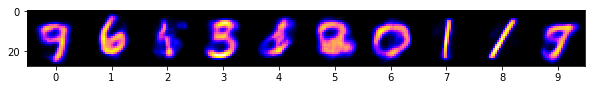

In [0]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 
predictions =np.zeros((img_cols * 1 ,img_cols* latent_dim))

for i in range(latent_dim):
    activate_aux = np.zeros((1,10))
    activate_aux[:,i] = 1 #activate a class
    predictions[:,i * img_cols:(i + 1) * img_cols] = np.squeeze(generator.predict(activate_aux))
    

plt.figure(figsize=(10, 10))
plt.imshow(predictions, cmap='gnuplot2')
pos = np.arange(img_cols/2, img_cols*latent_dim, img_cols)
plt.xticks(pos,range(latent_dim))
plt.show()

**e) Genere algunas imágenes aleatorias, comente cualitativamente con lo obtenido con el VAE tradicional ¿Cuál pareciera ser mejor para generar datos? ¿Por qué?**

In [0]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 

n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) #metodo de la transformada inversa
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
        
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
grid = norm.ppf(np.linspace(0.000005, 0.999995, n)) #en los extremos del intervalo de confianza

ValueError: ignored